<a href="https://colab.research.google.com/github/Uriel825/Experimentos-Pytorch/blob/master/Entrenando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F #capas sin parametros

In [0]:
class Net(nn.Module): #Necesita dos atributos init(tiene parametros) y forward(puede tener o no)
  def __init__(self, num_channels): 
    super(Net,self).__init__() #INicializar la clase padre
    
    #Capas convulusionales
    self.num_channels = num_channels
    self.conv1 = nn.Conv2d(3, self.num_channels, kernel_size=3, stride=1, padding=1 )  #El primer numeor es los canales que recibe 
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, kernel_size=3, stride=1, padding=1 )
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, kernel_size=3, stride=1, padding=1 ) #aumenta como los bits 
    #Capas lineales
    
    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4) 
    self.fc2 = nn.Linear(self.num_channels*4,6) #6 por lo daatos ya que son numeros con una sola mano desde  0 al 5 

    def fordward(self,x):
      #Empieza 3x64x64
      x = self.conv1(x) #num_channels X 64 X 64
      x = F.relu(F.max_pool2d(x, 2)) #num_channels x 32 x 32
      x = self.conv2(x) #num_channels*2 x 32 X 32 
      x = F.relu(F.max_pool2d(x, 2)) # num_channels* X 16 X 16 
      x = self.conv3(x) #num_channels*4 x16 x16
      x = F.relu(F.max_pool2d(x,2)) #num_channels*4 x8 x8
     
     #Flatten
      x = x.view(-1, self.num_channels*4*8*8)
     
     #fully conected
      x = self.fc1
      x = F.relu(x)
      x = self.fc2
    
    #log_softmax
      x = F.log_softmax(x,dim=1)

      return x


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'


test_signs  train_signs  val_signs


In [0]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [0]:
from plot_helpers import  imshow

Igual que con la ed los datos son una clase de python con dos parametros 

In [0]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDataset (Dataset):
  def __init__(self, base_dir, split="train", transform=None): #PARA TODO LO QUE LLEVE GUION BAJO SON DOS GUIONES BAJOS >:v
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)
    
    self.filenames = [os.path.join(path,f) for f in files if f.endswith(".jpg")]
    
    self.targets = [int(f[0]) for f in files]
    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self,idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image,self.targets[idx]


In [0]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train")

In [0]:
len(signs)

864

In [0]:
import torchvision.transforms as transforms

In [0]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train", transform=transforms.ToTensor())

In [0]:
dataloader = DataLoader(trainset, batch_size=32)

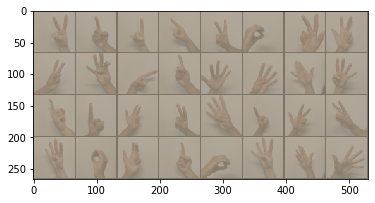

tensor([2, 1, 1, 1, 2, 0, 3, 3, 2, 4, 1, 1, 5, 4, 5, 4, 1, 1, 3, 2, 4, 1, 3, 2,
        4, 0, 3, 1, 0, 4, 5, 5])


In [0]:
from torchvision.utils import make_grid
for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break


In [0]:
device = torch.device('cuda')

In [0]:
import torch.optim as optim

In [0]:
device

device(type='cuda')

In [0]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum = 0.9)

In [0]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0 

  def update(self, val, size):
    self.S += val
    self.N += size
  
  def __call__(self):
    return self.S/float(self.N)